## Lab: Superdense Coding

Superdense coding is a quantum communication protocol in which two classical bits can be sent by transmitting only one qubit, provided the communicating parties share an entangled pair. Alice encodes her message by applying one of four possible operations to her qubit before sending it to Bob. Bob then performs a joint measurement in the Bell basis on both qubits, which directly produces the two-bit message. This enables the transmission of two classical bits using just a single qubit when prior entanglement is available.

### Task

Alice intends to send an **8-bit** random key to Bob using the superdense coding protocol. The task is to create a circuit that tests this protocol.

### Expected Output

The program should draw the circuit for each bit-pair, and after the transmission is complete display the full key Alice sent, the key Bob received, and report whether the transmission was successful or failed.

### Optional Challenge

Modify the code so that the circuit is generalized to support a flexible number of qubit pairs (e.g., 4, 8, 16 …), enabling parallel transfer.


Circuit for bit pair [0, 0]:


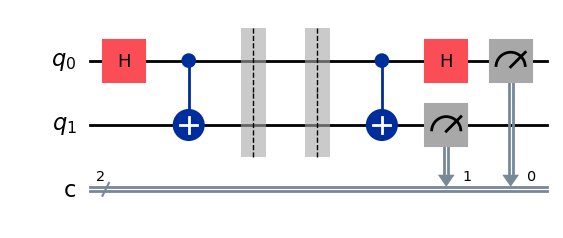

Circuit for bit pair [1, 0]:


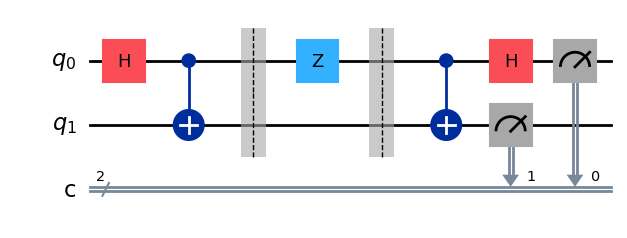

Circuit for bit pair [0, 1]:


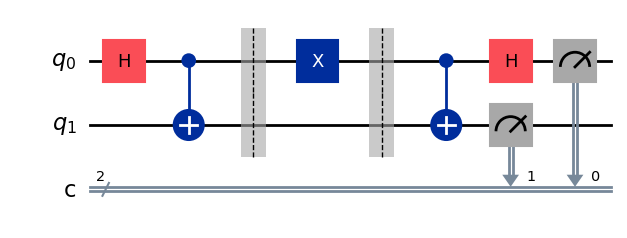

Circuit for bit pair [1, 1]:


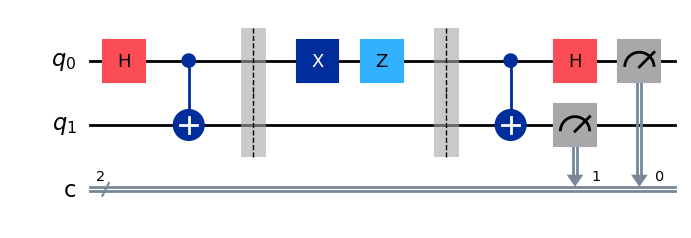

Alice sent:     00100111
Bob received:   00100111
Transmission OK: keys match.


In [1]:
from IPython.display import display

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer
import random

def bell_pair(qc, a, b):
    """Create a Bell pair between qubits a (Alice) and b (Bob)."""
    qc.h(a)
    qc.cx(a, b)
    return qc

def encode(qc, a, b0, b1):
    """Alice encodes her two classical bits onto her qubit."""
    qc.barrier()
    if (b0, b1) == (0, 1):
        qc.x(a)
    elif (b0, b1) == (1, 0):
        qc.z(a)
    elif (b0, b1) == (1, 1):
        qc.x(a)
        qc.z(a)
    qc.barrier()
    return qc

def decode(qc, a, b):
    """Bob decodes to recover Alice’s two classical bits."""
    qc.cx(a, b)
    qc.h(a)
    return qc

# ------------------------------------------------
#                main program
# ------------------------------------------------

# Alice creates an 8-bit random key
alice_bits = [random.randint(0, 1) for _ in range(8)]

n = 2         # number of qubits in the transmission line
bob_bits = [] # bits Bob receives
simulator = AerSimulator()

# loop: slice the key into bit pairs
# and send them over the 2-qubit circuit
for i in range(0, len(alice_bits), n):
    qc = QuantumCircuit(n, n)
    bitpair = alice_bits[i:i+n]
    
    # Alice encodes
    qc = bell_pair(qc, 0, 1)
    qc = encode(qc, 0, bitpair[0],bitpair[1])
 
    # ------- transmission lines -------
    
    # Bob decodes
    qc = decode(qc, 0, 1)
    qc.measure([0, 1], [0, 1])
    
    print(f"Circuit for bit pair {bitpair}:")
    display(circuit_drawer(qc, output="mpl"))
        
    result = simulator.run(qc, shots=1).result()
    counts = result.get_counts(qc)
    
    # Add the received pair into Bob's bitstring while 
    # reversing the bit order per Qiskit’s convention
    for key in counts:
        bob_bits.extend(int(b) for b in key[::-1])
    
# --- display results ---
print("Alice sent:    ", "".join(map(str, alice_bits)))
print("Bob received:  ", "".join(map(str, bob_bits)))

if bob_bits == alice_bits:
    print("Transmission OK: keys match.")
else:
    print("Transmission FAILED: keys differ.")